In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [4]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [6]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [9]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [10]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


# Training

In [11]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [12]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [13]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
) 

Will train until validation stopping metric hasn't improved in 20 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.70024 |  0.77877 |   2.4       
| 2     | 0.83331 |  0.84851 |   4.6       
| 3     | 0.87371 |  0.87852 |   6.9       
| 4     | 0.89311 |  0.89344 |   9.2       
| 5     | 0.90396 |  0.90333 |   11.5      
| 6     | 0.90765 |  0.90484 |   13.7      
| 7     | 0.91457 |  0.90759 |   16.0      
| 8     | 0.91751 |  0.90796 |   18.2      
| 9     | 0.91888 |  0.91322 |   20.5      
| 10    | 0.92416 |  0.91996 |   22.8      
| 11    | 0.92222 |  0.92151 |   25.0      
| 12    | 0.92760 |  0.92390 |   27.2      
| 13    | 0.92817 |  0.92473 |   29.5      
| 14    | 0.92678 |  0.92413 |   31.7      
| 15    | 0.93077 |  0.92740 |   33.9      
| 16    | 0.92988 |  0.92825 |   36.2      
| 17    | 0.92974 |  0.92802 |   38.4      
| 18    | 0.93185 |  0.92865 |   40.7      
| 19    | 0.92834 |  0.92921 |   42.9      
| 20

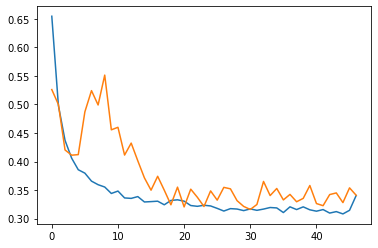

In [14]:
# plot losses
plt.plot(clf.history['train']['loss'])
plt.plot(clf.history['valid']['loss'])

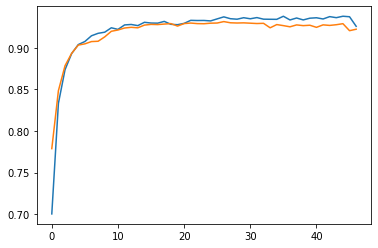

In [15]:
# plot auc
plt.plot([-x for x in clf.history['train']['metric']])
plt.plot([-x for x in clf.history['valid']['metric']])

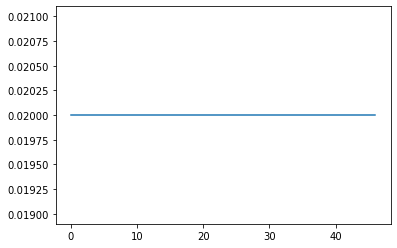

In [16]:
# plot learning rates
plt.plot([x for x in clf.history['train']['lr']])

## Predictions

In [17]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : -0.93162286617784
FINAL TEST SCORE FOR census-income : 0.9275803212338323


# Save and load Model

In [18]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [19]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [20]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9275803212338323


In [21]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [22]:
clf.feature_importances_

array([0.12494301, 0.01432264, 0.00388674, 0.0528206 , 0.04731573,
       0.16577052, 0.1039479 , 0.05775202, 0.02034662, 0.00263981,
       0.20749286, 0.08520639, 0.05643375, 0.05712142])

# Local explainability and masks

In [23]:
explain_matrix, masks = clf.explain(X_test)

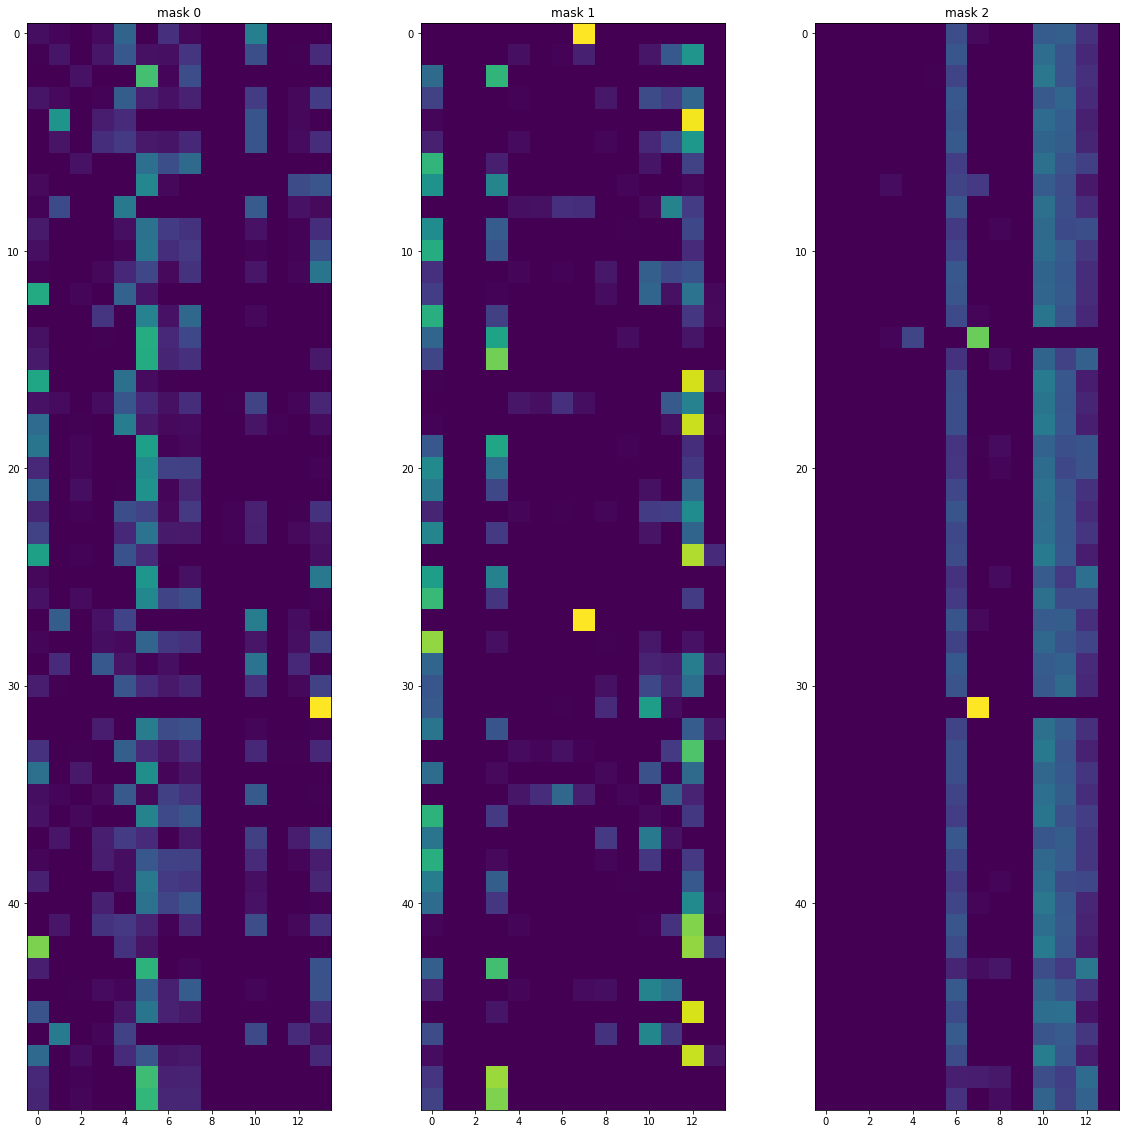

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [26]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-error:0.13784
Will train until validation_0-error hasn't improved in 40 rounds.
[10]	validation_0-error:0.12915
[20]	validation_0-error:0.12667
[30]	validation_0-error:0.12481
[40]	validation_0-error:0.12481
[50]	validation_0-error:0.12419
[60]	validation_0-error:0.12419
[70]	validation_0-error:0.12419
[80]	validation_0-error:0.12449
[90]	validation_0-error:0.12325
[100]	validation_0-error:0.12201
[110]	validation_0-error:0.12170
[120]	validation_0-error:0.12201
[130]	validation_0-error:0.12232
[140]	validation_0-error:0.12294
Stopping. Best iteration:
[103]	validation_0-error:0.12108



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [27]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9335963387010509
0.9243623615745874
